In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

HDD_path = r'E:\EME data\Clean data\Analysis Output\FTSE and Terror merged.xlsx'
Dropbox_path = r'C:\Users\nfa\Dropbox\Ed\Ed Uni work\EME\Data\EME Data Backup 30.11.2017\Clean Data\Analysis Output\FTSE and Terror merged.xlsx'

In [2]:
data1 = pd.read_excel( Dropbox_path, parse_dates=True, index_col=0)



In [3]:
def event_criteria(data, n = 10 , criteria = 'attack', drop = False):
    ### A function that creates a dataframe with a dummy variable for observations matching our event criteria, default is
    ### just a dummy for attack. (Identical to the 'terror attack' dummy)
    
    
    #Creating a new dataframe so we don't overwrite the original
    data_event = data.copy()
    
    #Setting the eligible variable to 0 and then switching it on if the observation corresponds to the specified attack
    data_event['attack eligible'] = 0
    
    if criteria == 'fatalities':
        data_event.loc[(data_event['nkill'] > n), 'attack eligible'] = 1
        
    if criteria == 'wounded':
        data_event.loc[(data_event['nwound'] > n), 'attack eligible'] = 1
        
    if criteria == 'damage':
        data_event.loc[(data_event['propvalue'] > n), 'attack eligible'] = 1
    #This should be the default case where criteria is just an attack has occurred 
    if criteria == 'attack':
        data_event.loc[(data_event['terrorattack'] == 1), 'attack eligible'] = 1
    
    #This returns a dataframe ONLY with the terror attacks
    if drop == True:   
        data_event = data_event[data_event['attack eligible'] == 1].copy()
    return data_event


def window_criteria(data, window_type = 'all'):
    ##This function creates two variables that describe the number of days before/after the next attack OR the next eligible
    ##attack
    
    
    #Creating a copy to prevent editing the original data
    data_window = data.copy()
    
    '''
    Whether our windows are determined by the next attack or eligible attack:
    
    The next attack will mean any attack in the timeframe marks the close of that window.
    
    Eligible attack means we only consider like to like to close the window. 
    
    E.g. There's an attack on day 10 with nkill > 10 and an attack on day 12 with nkill = 3. With 'all' specified the post
    window will be 2 days for day 10 and pre window will be 2 days for day 12. With 'eligible' on, the post window on day 10
    will ignore day 12 and only close when another attack with nkill>10 occurs.
    
    '''
    
    if window_type == 'eligible' :
        condition = data_window['attack eligible'] == 1
    if window_type == 'all':
        condition = data_window['terrorattack'] == 1
    
    
    data_window['Index 2'] = data_window.index
    
    data_window.loc[condition, 'window1'] = data_window['Index 2']
    data_window.loc[condition, 'window2'] = data_window['Index 2']
    
    data_window['window2'] = data_window['window2'].fillna(method = 'ffill', axis = 0)
    data_window['window2'] = data_window['window2'].shift(1)
    data_window['pre window gap'] = data_window['window1'] - data_window['window2']

    data_window.loc[condition, 'window3'] = data_window['Index 2']
    
    data_window['window3'] = data_window['window3'].fillna(method = 'backfill', axis = 0)
    data_window['window3'] = data_window['window3'].shift(-1)
    data_window['post window gap'] = data_window['window3'] - data_window['window1']
    
    data_window = data_window.drop([  'window3'], axis = 1)
    return data_window




def plotter(data,criteria_type, number, pre_window = 5, post_window = 5):
    events = data.loc[(data['attack eligible'] == 1)
                      & (data['pre window gap'] >= pre_window)
                      & (data['post window gap'] >= post_window)]
    fig, axes = plt.subplots(figsize = (10, 5))
    event_index = list(events.index)
  
    for i in np.arange(len(event_index)):
        
    
        

        df1 = data.iloc[event_index[i] - pre_window + 1 : event_index[i], :].copy()
        df1 = df1.append(data.iloc[event_index[i]: (event_index[i] + post_window), :])


        
        df1 = df1.reset_index(drop = True)
        df1['Reindexed'] = (df1['FTSE 100 - PRICE INDEX']/df1.loc[0, 'FTSE 100 - PRICE INDEX'])*1000
        axes.plot(df1.index, df1['Reindexed'], alpha = 0.5, lw = 0.8)
    
    
    
    total_mean = []
    day_list = np.arange( pre_window - 1 + post_window )
    for day in day_list:
        running_mean = 0
        for i in np.arange(len(event_index)):
            
             df1 = data.iloc[event_index[i] - pre_window + 1 : event_index[i], :].copy()
             df1 = df1.append(data.iloc[event_index[i]: (event_index[i] + post_window), :])



             df1 = df1.reset_index(drop = True)
             df1['Reindexed'] = (df1['FTSE 100 - PRICE INDEX']/df1.loc[0, 'FTSE 100 - PRICE INDEX'])*1000
             running_mean = running_mean + df1.loc[day , 'Reindexed'  ]
        total_mean = total_mean + [running_mean/len(event_index)]
    axes.plot(df1.index, total_mean, color = 'blue')
    plt.axvline(x=4, color = 'r', lw = 0.5)
    axes.set_xticks(day_list)
    axes.set_xticklabels(np.arange( (pre_window - 1)*-1, post_window))
    if criteria_type == 'attack':
        axes.set_title('Terror Attacks and FTSE Returns')
    else:
        axes.set_title('Terror Attacks and FTSE Returns: ' + str(criteria_type) +'>' + str(number)) 
    axes.set_xlabel('Days before/after attack')
    axes.set_ylabel('FTSE returns')
    axes.set_ylim((950, 1050))
    axes.annotate('Mean response', xy = (6, 1010))
    fig.tight_layout()
    
    
def plot_data( data, criteria_type  = 'attack', number = 10, window_type = 'all', pre_window = 5, post_window = 5, savefig =False):
    data_to_plot = event_criteria(data, criteria = criteria_type, n = number)
    data_to_plot = window_criteria(data_to_plot, window_type= window_type)
    plotter(data_to_plot, criteria_type= criteria_type, number = number, pre_window= pre_window, post_window= post_window)
    
    if savefig == True:
        path1 = "C:\\Users\\ed\\Dropbox\\Ed\\Ed Uni work\\EME\\Data\\Figures\\Terror Attack and FTSE "
        path2 = criteria_type + str(number) + '.png'
        path = path1 + path2
        plt.savefig(path, bbox_inches = 'tight')

# d1 = event_criteria(data1)
# d2 = window_criteria(d1)
# d2.head(20)
    

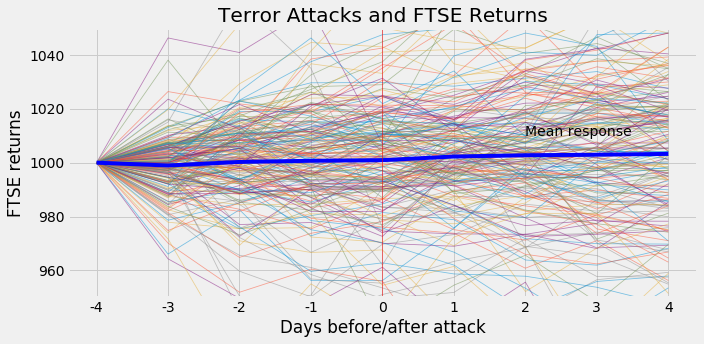

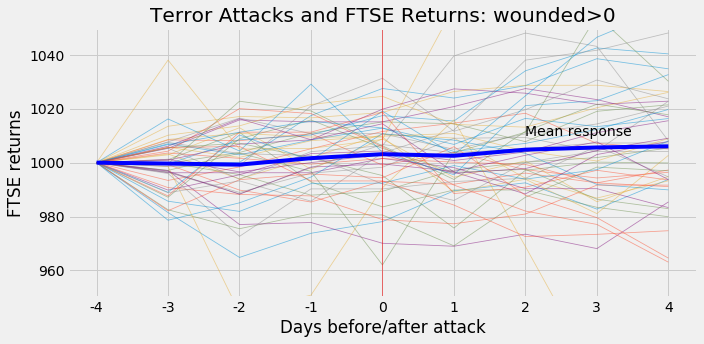

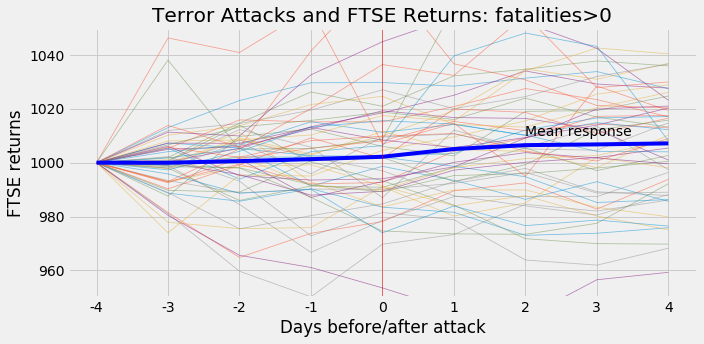

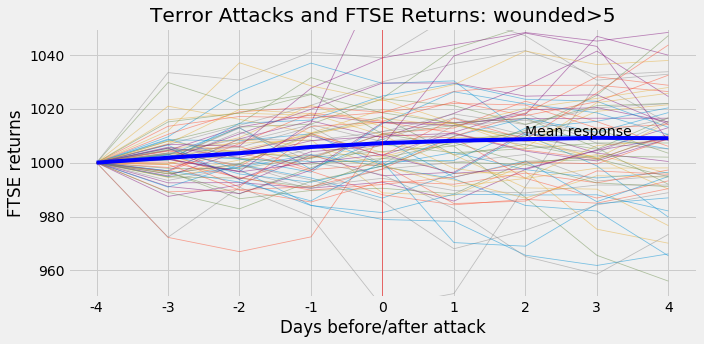

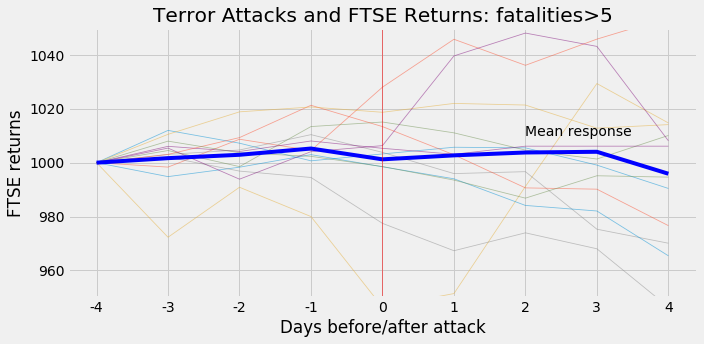

In [7]:

plot_data(data1, savefig = False)
plot_data(data1, criteria_type='wounded', number = 0, savefig= False)
plot_data(data1, criteria_type='fatalities', number = 0, savefig= False)
plot_data(data1, criteria_type='wounded', number =5, window_type= 'eligible', savefig = False)
plot_data(data1, criteria_type='fatalities', number =5, window_type = 'eligible', savefig = False)


In [7]:
# kill_5 = event_criteria(data1, n = 5, criteria = 'fatalities', drop = True)
# wound_5 = event_criteria(data1, n = 5, criteria = 'wounded', drop = True)
# prop_100000 = event_criteria(data1, n = 100000, criteria = 'damage', drop = True)


# kill_5.to_excel(r'C:\Users\nfa\Dropbox\Ed\Ed Uni work\EME\Data\kill_5_events.xls')
# wound_5.to_excel(r'C:\Users\nfa\Dropbox\Ed\Ed Uni work\EME\Data\wound_5_events.xls')
# prop_100000.to_excel(r'C:\Users\nfa\Dropbox\Ed\Ed Uni work\EME\Data\prop_100000_events.xls')

5.47 s ± 53.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


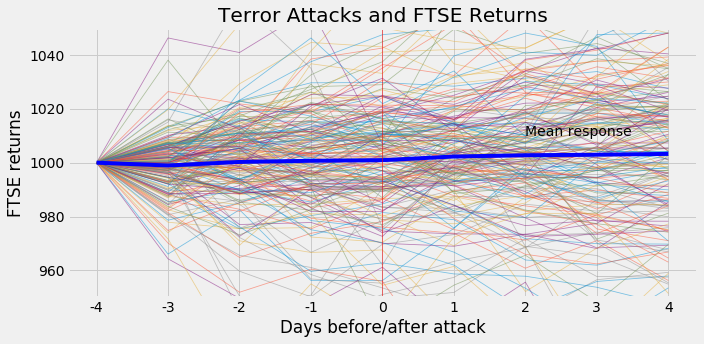

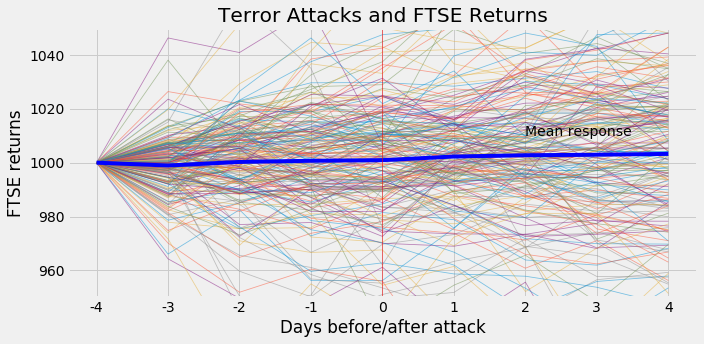

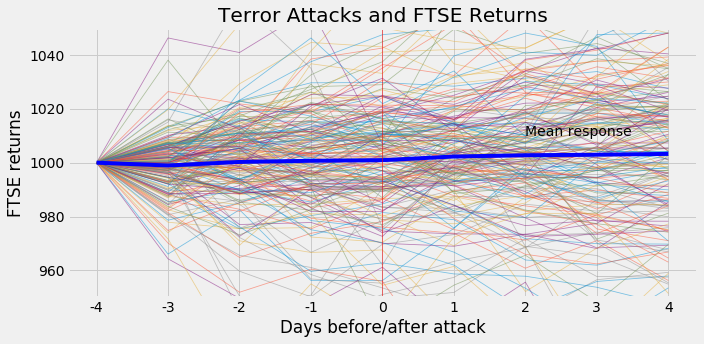

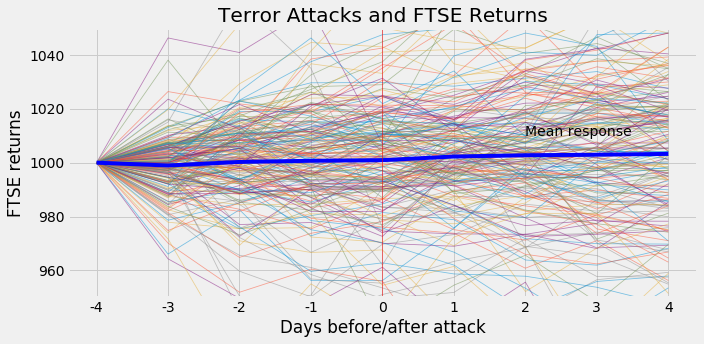

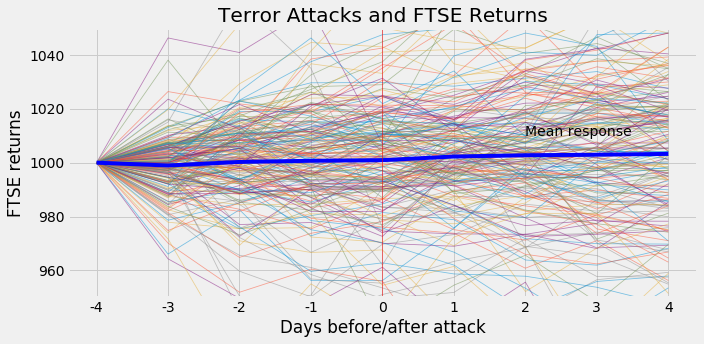

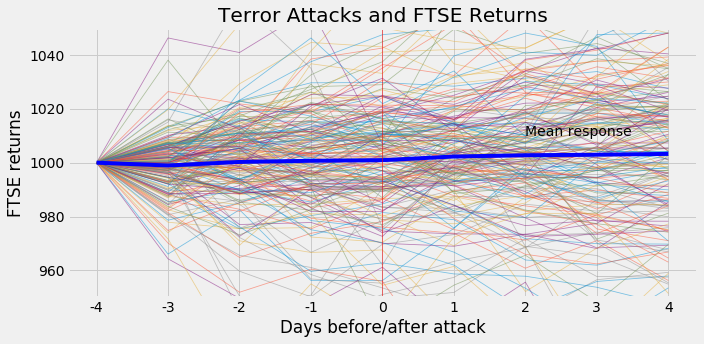

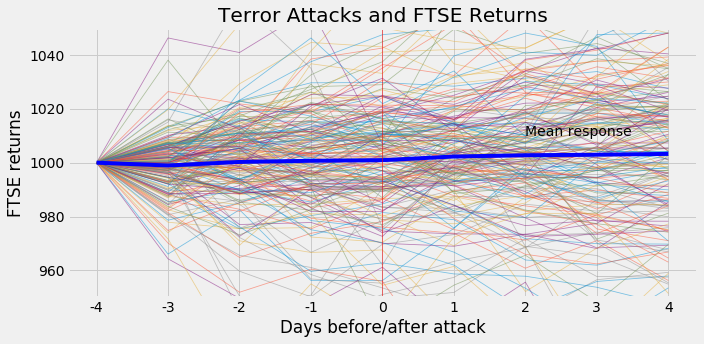

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
%%timeit
plot_data(data1, savefig = False)